# Comparando estratégias

- Amostra por incerteza
- Amostragem aleatória
- Consulta por comitê
- Aprendizado passivo
- Redução do erro esperado

In [1]:
import numpy as np
import pandas as pd
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [2]:
# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [3]:
from copy import deepcopy

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

In [6]:
from timeit import default_timer as timer

In [7]:
from sklearn.model_selection import ShuffleSplit

## Classificadores

### Algoritmos

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### Conjunto de dados

In [9]:
from sklearn.datasets import load_iris, load_digits, load_wine, load_breast_cancer

## Amostra por incerteza

In [10]:
def uncertain_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):
    
    from modAL.uncertainty import classifier_uncertainty
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_test, y_test = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    classifier.fit(X_train,y_train)

    learner = ActiveLearner (
        estimator=classifier,
        query_strategy=uncertainty_sampling
    )
    uncertain_sample_score = learner.score(X_test, y_test)

    performance_history.append(uncertain_sample_score)

    total_of_samples = 0
    while (total_of_samples != n_queries - 1):
        
        #X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size=0.03)
        
        idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
        X_train, y_train = X_raw[idx_data[idx_bag][0][idx]], y_raw[idx_data[idx_bag][0][idx]]
        #print("WHILE", classifier_uncertainty(learner, X_train[0].reshape(1,-1)))
        if classifier_uncertainty(learner, X_train[0].reshape(1,-1)) > 0.2: #ASK04
            #print("IF", learner.score(X_test, y_test))
            sample_size = sample_size + len(X_train)
            learner.teach(X_train, y_train)
            uncertain_sample_score = learner.score(X_test, y_test)
            performance_history.append(uncertain_sample_score)
            #print("Uncertainty Sampling score: ", uncertain_sample_score)
            performance_history.append(uncertain_sample_score)    
        total_of_samples = total_of_samples + 1 #ASK05
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 0}

## Amostragem aleatória

In [11]:
def random_sampling(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):
        
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()

    for i in range(1,n_queries+1):

        #high = X_raw.shape[0] = qtd amostras no dataset
        training_indices = np.random.randint(low=0, high=len(X_raw[idx_data[idx_bag][0]]), size=k+i) #high = qtd elementos na bag
        sample_size = sample_size + len(training_indices)

        X_train = X_raw[idx_data[idx_bag][0][training_indices]] #ASK06
        y_train = y_raw[idx_data[idx_bag][0][training_indices]]

        X_test = np.delete(X_raw, idx_data[idx_bag][0][training_indices], axis=0)
        y_test = np.delete(y_raw, idx_data[idx_bag][0][training_indices], axis=0)

        classifier.fit(X_train, y_train)

        #pred = classifier.predict(X_test)
        #print("Random Sampling score: ", knn.score(X_test,y_test))
        performance_history.append(classifier.score(X_test,y_test))

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history, 
         "time_elapsed": time_elapsed,
         "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
         "Strategy": 1}

## Consulta por comitê

In [12]:
def query_by_committee(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.models import ActiveLearner, Committee
    from modAL.disagreement import vote_entropy_sampling

    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()


    for i in range(1,n_queries+1):

        learner_list = []

        for j in range(1,n_queries+1): # Loop para criação do comitê

            X_train, _, y_train, _ = train_test_split(X_raw[idx_data[idx_bag][0]], y_raw[idx_data[idx_bag][0]], train_size=0.03)
            sample_size = sample_size + len(X_train)
            
            # initializing learner
            learner = ActiveLearner(
                estimator=which_classifier(k, classifier = 'rfc'),
                query_strategy=uncertainty_sampling,
                X_training = X_train, y_training = y_train 
            )
            learner_list.append(learner)

        # assembling the committee
        committee = Committee(
            learner_list=learner_list,
            query_strategy=vote_entropy_sampling)

        X_pool, y_pool = X_raw[idx_data[idx_bag][0]], y_raw[idx_data[idx_bag][0]]

        # query by committee
        for idx in range(n_queries):
            query_idx, query_instance = committee.query(X_pool, n_instances = k+1)
            sample_size = sample_size + len(query_idx)
            committee.teach(
                X=X_pool[query_idx],
                y=y_pool[query_idx]
            )

            X_pool = np.delete(X_pool, query_idx, axis=0)
            y_pool = np.delete(y_pool, query_idx)
        performance_history.append(committee.score(X_pool, y_pool))

        #print(idx, n_queries, "Query by Committee: ", committee.score(X_pool, y_pool))

        
    end = timer()
    time_elapsed = end - start

    return { "performance_history": performance_history, 
         "time_elapsed": time_elapsed,
         "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
         "Strategy": 2}

## Exp Error Reduction

In [64]:
def exp_error_reduction(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator=classifier,
        X_training=X_train, 
        y_training=y_train
    )
    exp_er_score = learner.score(X_pool, y_pool)
    performance_history.append(exp_er_score)

    total_of_samples = 0
    while (total_of_samples != n_queries):
        exp_error_idx = expected_error_reduction(learner, X_pool, 'binary', n_instances=init_size)[0]

        learner.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        sample_size = sample_size + init_size
        exp_er_score = learner.score(X_pool, y_pool)
    
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        performance_history.append(exp_er_score)
        
        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 3}

## Exp Model Change

In [73]:
def exp_model_change(X_raw, y_raw, idx_data, idx_bag, classifier, init_size, n_queries):

    from modAL.expected_error import expected_error_reduction
    sample_size = 0 #contador de amostras utilizadas pela estratégia
    performance_history = []
    start = timer()
    
    # parte randomica inicial da estratégia
    initial_idx = np.random.choice(range(len(idx_data[idx_bag][0])), size=init_size, replace=False)
    X_train, y_train = X_raw[idx_data[idx_bag][0][initial_idx]], y_raw[idx_data[idx_bag][0][initial_idx]]
    X_pool, y_pool = X_raw[idx_data[idx_bag][1]], y_raw[idx_data[idx_bag][1]]
    
    sample_size = sample_size + len(X_train)

    learner = ActiveLearner (
        estimator=classifier,
        X_training=X_train, 
        y_training=y_train
    )
    
#     performance_history.append(uncertain_sample_score)

    total_of_samples = 0
    while (total_of_samples != n_queries):
        exp_error_idx = np.random.choice(range(len(X_pool)), size=init_size, replace=False)
        aux = deepcopy(learner)

        aux.teach(X_pool[exp_error_idx], y_pool[exp_error_idx])
        score_aux = aux.score(X_pool, y_pool)
        score_learner = learner.score(X_pool, y_pool)
        if score_aux > score_learner:
            #print(total_of_samples, " YES SCIENCE")
            learner = deepcopy(aux)
            sample_size = sample_size + init_size
        np.delete(X_pool, exp_error_idx, axis=0)
        np.delete(y_pool, exp_error_idx, axis=0)
        performance_history.append(learner.score(X_pool, y_pool))

        total_of_samples = total_of_samples + 1
    
    end = timer()
    time_elapsed = end - start
    
    return { "performance_history": performance_history, 
             "time_elapsed": time_elapsed,
             "sample_size": sample_size, # RETORNAR TODAS AS AMOSTRAS DE CADA PERFORMANCE OU SÓ DO ULTIMO
             "Strategy": 4}

### Setup

In [14]:
def which_dataset(dataset = "iris", n_splits = 5):
    
    # Futuramente essa etapa será ajustada para receber qualquer dataset (ou lista com datasets)
    if (dataset == "iris"):
        data = load_iris()
        X_raw = data['data']
        y_raw = data['target']
    
    if (dataset == "wine"):
        data = load_wine()
        X_raw = data['data']
        y_raw = data['target']
        
    if (dataset == "digits"):
        data = load_digits()
        X_raw = data['data']
        y_raw = data['target']
        
    # cross validation bags
    data_cv = ShuffleSplit(n_splits= n_splits, test_size=0.3, random_state=0) #n_splits
    
    # extraindo ids do data_cv
    idx_data = []
    for train_index, test_index in data_cv.split(X_raw):
            idx_data.append([train_index, test_index])

    return X_raw, y_raw, idx_data

In [15]:
def which_classifier(parameters, classifier = 'knn'):
    
    if (classifier == 'knn'):
        return KNeighborsClassifier(parameters)
    if (classifier == 'rfc'):
        return RandomForestClassifier(n_estimators = 5)

In [75]:
n_queries = 10 # cost
n_splits = 5 # number of bags cv
total_performance_history = []
k = 3 #parameter to knn classifier

idx_bag = 10

classifier = which_classifier(k, classifier = 'rfc')
X_raw, y_raw, idx_data = which_dataset("iris")

#para cada i em idx_bag ("n_splits") (1 a 5)
for idx_bag in range(n_splits):
    print(idx_bag, " uncertain_sampling")
    total_performance_history.append(uncertain_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
for idx_bag in range(n_splits):
    print(idx_bag, " random sampling")
    total_performance_history.append(random_sampling(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
for idx_bag in range(n_splits):
    print(idx_bag, " query_by_committee")
    total_performance_history.append(query_by_committee(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
for idx_bag in range(n_splits):
    print(idx_bag, " exp error reduction")
    total_performance_history.append(exp_error_reduction(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))
for idx_bag in range(n_splits):
    print(idx_bag, " exp model change")
    total_performance_history.append(exp_model_change(deepcopy(X_raw), deepcopy(y_raw), idx_data, idx_bag, classifier, k, n_queries))

0  uncertain_sampling
1  uncertain_sampling
2  uncertain_sampling
3  uncertain_sampling
4  uncertain_sampling
0  random sampling
1  random sampling
2  random sampling
3  random sampling
4  random sampling
0  query_by_committee
1  query_by_committee
2  query_by_committee
3  query_by_committee
4  query_by_committee
0  exp error reduction
0   [39  3 10]
1   [37 10  7]
2   [30 40 33]
3   [29 31 19]
4   [ 5 28 29]
5   [29 39  5]
6   [13 28 12]
7   [34 37  4]
8   [ 6 29 37]
9   [ 3  6 36]
1  exp error reduction
0   [12  2 27]
1   [11  5 29]
2   [43 25 14]
3   [23  8 36]
4   [16 38 39]
5   [30 12 38]
6   [ 0  8 16]
7   [31 14  0]
8   [ 0 31  6]
9   [ 5  9 14]
2  exp error reduction
0   [20  3 36]
1   [ 5 13 43]
2   [11 31 17]
3   [44  2 30]
4   [14 19 34]
5   [ 3 17 27]
6   [38  8  3]
7   [39 24 27]
8   [ 3 37 38]
9   [ 4 34 14]
3  exp error reduction
0   [0 1 2]
1   [ 4 11 35]
2   [ 5 41 12]
3   [19 27 34]
4   [25 40 14]
5   [41 16 43]
6   [24 11 10]
7   [ 3 16 20]
8   [34 33  3]
9   [27  6 

In [76]:
total_performance_history

[{'performance_history': [0.7555555555555555,
   0.4666666666666667,
   0.4666666666666667,
   0.6,
   0.6],
  'time_elapsed': 0.06700431799981743,
  'sample_size': 9,
  'Strategy': 2},
 {'performance_history': [0.26666666666666666],
  'time_elapsed': 0.03336070299974381,
  'sample_size': 3,
  'Strategy': 2},
 {'performance_history': [0.35555555555555557],
  'time_elapsed': 0.02156145299977652,
  'sample_size': 3,
  'Strategy': 2},
 {'performance_history': [0.6888888888888889,
   0.37777777777777777,
   0.37777777777777777],
  'time_elapsed': 0.027471504999994067,
  'sample_size': 6,
  'Strategy': 2},
 {'performance_history': [0.7555555555555555],
  'time_elapsed': 0.022134285999527492,
  'sample_size': 3,
  'Strategy': 2},
 {'performance_history': [0.6575342465753424,
   0.8482758620689655,
   0.4861111111111111,
   0.6573426573426573,
   0.7253521126760564,
   0.7021276595744681,
   0.9571428571428572,
   0.7571428571428571,
   0.9565217391304348,
   0.948905109489051],
  'time_elaps

In [77]:
df = pd.DataFrame.from_dict(total_performance_history)

In [78]:
df = df.explode('performance_history')

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 216 entries, 0 to 24
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   performance_history  216 non-null    object 
 1   time_elapsed         216 non-null    float64
 2   sample_size          216 non-null    int64  
 3   Strategy             216 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 8.4+ KB


## Visualization

In [80]:
#  https://seaborn.pydata.org/examples/scatterplot_sizes.html
import seaborn as sns

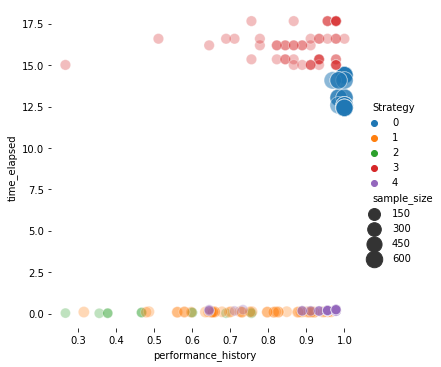

In [81]:
g = sns.relplot(
    data= df,
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

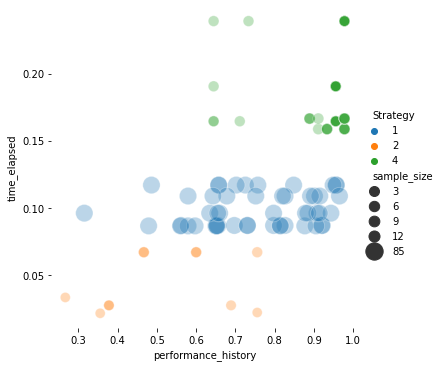

In [110]:
g = sns.relplot(
    data= df[(df.Strategy != 0) & (df.Strategy != 3)],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=3), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)

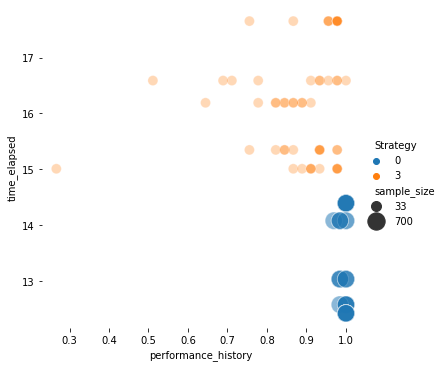

In [114]:
g = sns.relplot(
    data= df[(df.Strategy == 0) | (df.Strategy == 3)],
    x="performance_history", y="time_elapsed",
    hue="Strategy", size="sample_size",
    palette=sns.color_palette(n_colors=2), sizes=(100, 300), alpha=0.3
)
g.ax.xaxis.grid(True, "minor", linewidth=.25)
g.ax.yaxis.grid(True, "minor", linewidth=.25)
_ = g.despine(left=True, bottom=True)